In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
main_dir = '/content/drive/MyDrive/Colab Notebooks/GAN'

In [ ]:
%cd $main_dir
!ls

/content/drive/MyDrive/Colab Notebooks/GAN
saved_models  saved_results  wGAN_gradient_clipping


In [ ]:
from time import time, localtime
from pathlib import Path

experiment_name = "fashion_mnist"
method = "wgan"

this_dir = Path.cwd()
model_dir = this_dir / "saved_models" / experiment_name / method
output_dir = this_dir / "saved_results" / experiment_name / method

if not model_dir.exists():
    model_dir.mkdir(parents=True)

if not output_dir.exists():
    output_dir.mkdir(parents=True)

In [ ]:
def sec_to_hours(seconds):
    a = seconds//3600
    b = (seconds % 3600)//60
    c = (seconds % 3600) % 60
    d = "{:.0f} hours {:.0f} mins {:.0f} seconds".format(a, b, c)
    return d

### **Load data**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets.fashion_mnist import load_data

In [ ]:
(train_set, label_set), (_, _) = load_data()

4422102/4422102 [==============================] - 0s 0us/step


In [ ]:
print(train_set.shape)
print(label_set.shape)

(60000, 28, 28)
(60000,)


In [ ]:
def plot_img(x, sample=20):
  x = (x + 1)/2.0
  plt.figure()
  for i in range(sample):
    plt.subplot(4, 5, i + 1)
    plt.axis('off')
    plt.imshow(x[i], cmap='gray_r')
  plt.show()

In [ ]:
def data_processing(x):
  x = (x - 127.5)/127.5
  x = np.expand_dims(x, axis=-1)
  x = x.astype('float32')
  return x

In [ ]:
x_train = data_processing(train_set)
idx = label_set.flatten() == 7
x_train = x_train[idx]

In [ ]:
print(x_train.shape)

(6000, 28, 28, 1)


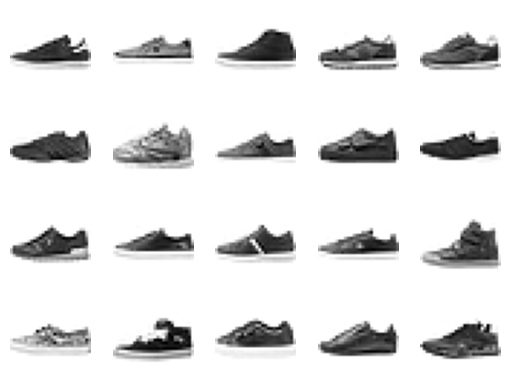

In [ ]:
plot_img(x_train)

# **Create Model**

In [ ]:
from tensorflow import reduce_mean, clip_by_value
from keras.models import Sequential
from keras.initializers import RandomNormal
from keras.layers import Conv2D, Dense, Flatten, BatchNormalization, LeakyReLU, Reshape, Conv2DTranspose, Dropout
from keras.optimizers import RMSprop
from keras.constraints import Constraint

In [ ]:
def wasserstein_loss(y_true, y_pred):
  return reduce_mean(y_true * y_pred)

In [ ]:
# clip model weights for prevent exploding gradient

class ClipConstraint(Constraint):
	# truyền vào giá trị cận trên
	def __init__(self, clip_value):
		self.clip_value = clip_value

	# clip model weights to hypercube
	def __call__(self, weights):
		return clip_by_value(weights, -self.clip_value, self.clip_value)

	# get the config
	def get_config(self):
		return {'clip_value': self.clip_value}

In [ ]:
# Hyperparameters
EPOCHS = 10
BATCH_SIZE = 64
lr = 0.0003
clip_value = 0.02
latent_dim = 128

### **Discriminator - Critic**

In [ ]:
def _critic(input_shape=(28,28,1)):
  init = RandomNormal(stddev=0.02)
  clip = ClipConstraint(clip_value)

  model = Sequential()

  model.add(Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init, kernel_constraint=clip, input_shape=(input_shape)))
  model.add(BatchNormalization())
  model.add(LeakyReLU(0.2))

  model.add(Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init, kernel_constraint=clip))
  model.add(BatchNormalization())
  model.add(LeakyReLU(0.2))

  model.add(Flatten())
  model.add(Dense(512))
  model.add(LeakyReLU(0.2))
  model.add(Dense(1))

  model.compile(loss=wasserstein_loss, optimizer=RMSprop(learning_rate=lr))
  return model

### **Generator**

In [ ]:
def _generator(latent_dim = latent_dim):
  init = RandomNormal(stddev=0.02)
  n_nodes = 7 * 7 * 256

  model = Sequential()

  model.add(Dense(n_nodes, kernel_initializer=init, input_shape=(latent_dim,)))
  model.add(LeakyReLU(0.2))
  model.add(Reshape((7, 7, 256)))

  model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init))
  model.add(BatchNormalization())
  model.add(LeakyReLU(0.2))

  model.add(Conv2DTranspose(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init))
  model.add(BatchNormalization())
  model.add(LeakyReLU(0.2))

  model.add(Conv2D(1, (7,7), strides=(1,1), padding='same', activation='tanh', kernel_initializer=init))

  return model

### **GAN model**

In [ ]:
def _gan_model(generator, critic):
  for layer in critic.layers:
    if not isinstance(layer, BatchNormalization):
      layer.trainable = False

  model = Sequential()

  model.add(generator)
  model.add(critic)

  model.compile(loss=wasserstein_loss, optimizer=RMSprop(lr))
  return model

In [ ]:
critic = _critic()
critic.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1088      
                                                                 
 batch_normalization (BatchN  (None, 14, 14, 64)       256       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         131200    
                                                                 
 batch_normalization_1 (Batc  (None, 7, 7, 128)        512       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 7, 7, 128)         0

/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [ ]:
generator = _generator()
generator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 12544)             1618176   
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 12544)             0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 128)      524416    
 nspose)                                                         
                                                                 
 batch_normalization_2 (Batc  (None, 14, 14, 128)      512       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 14, 14, 128)      

In [ ]:
gan_model = _gan_model(generator, critic)

In [ ]:
gan_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 28, 28, 1)         2277633   
                                                                 
 sequential (Sequential)     (None, 1)                 3345345   
                                                                 
Total params: 5,622,978
Trainable params: 2,277,633
Non-trainable params: 3,345,345
_________________________________________________________________


### **Generate sample**

In [ ]:
# Real sample has label -1
def generate_real_sample(datasets, samples):
  idx = np.random.randint(0, datasets.shape[0], samples)
  y = -np.ones((samples, 1))
  return datasets[idx], y

In [ ]:
def generate_noise_vector(latent_dim, samples):
  noises = np.random.normal(size=(latent_dim*samples))
  noises = noises.reshape(samples, latent_dim)
  return noises

In [ ]:
# Fake sample has label 1
def generate_fake_sample(g_model, latent_dim, samples):
  noises = generate_noise_vector(latent_dim, samples)
  fake_samples = g_model.predict(noises)
  y = np.ones((samples, 1))
  return fake_samples, y

### **Train model**

In [ ]:
def summarize_performance(generator, latent_dim):
  x, _ = generate_fake_sample(generator, latent_dim, 20)
  plot_img(x, 20)

In [ ]:
# Loss history
critic_fake_loss, critic_real_loss, gan_loss = [], [], []

In [ ]:
def train_model(datasets, gan_model, generator, critic, latent_dim=latent_dim, epochs=EPOCHS, BATCH_SIZE=BATCH_SIZE, n_critic=5):
  batch_per_epochs = int(datasets.shape[0] / BATCH_SIZE)
  n_steps = batch_per_epochs * epochs
  half_batch = int(BATCH_SIZE / 2)

  for i in range(n_steps):
    cf_tmp, cr_tmp = [], []

    # Train critic first
    for j in range(n_critic):
      x_real, y_real = generate_real_sample(datasets, half_batch)
      cr_loss = critic.train_on_batch(x_real, y_real)

      x_fake, y_fake = generate_fake_sample(generator, latent_dim, half_batch)
      cf_loss = critic.train_on_batch(x_fake, y_fake)

      cr_tmp.append(cr_loss)
      cf_tmp.append(cf_loss)

    critic_fake_loss.append(np.mean(cf_tmp))
    critic_real_loss.append(np.mean(cr_tmp))

    # Train generator
    noises = generate_noise_vector(latent_dim, BATCH_SIZE)
    labels = -np.ones((BATCH_SIZE, 1))

    g_loss = gan_model.train_on_batch(noises, labels)
    gan_loss.append(g_loss)

    print('>%d, cf=%.3f, cr=%.3f g=%.3f' % (i+1, critic_fake_loss[-1], critic_real_loss[-1], g_loss))
    if ((i+1) % batch_per_epochs == 0):
      summarize_performance(generator, latent_dim)

1/1 [==============================] - 0s 17ms/step
>1, cf=-5.066, cr=-62.448 g=68.319
1/1 [==============================] - 0s 17ms/step
>2, cf=-28.049, cr=-191.568 g=190.711
1/1 [==============================] - 0s 32ms/step
>3, cf=-201.128, cr=-323.819 g=329.674
1/1 [==============================] - 0s 40ms/step
>4, cf=-372.292, cr=-473.679 g=514.616
1/1 [==============================] - 0s 25ms/step
>5, cf=-526.752, cr=-618.220 g=704.087
1/1 [==============================] - 0s 25ms/step
>6, cf=-750.063, cr=-787.620 g=947.714
1/1 [==============================] - 0s 24ms/step
>7, cf=-1013.595, cr=-984.018 g=1161.946
1/1 [==============================] - 0s 23ms/step
>8, cf=-1262.288, cr=-1207.893 g=1427.263
1/1 [==============================] - 0s 18ms/step
>9, cf=-1509.769, cr=-1433.722 g=1630.159
1/1 [==============================] - 0s 18ms/step
>10, cf=-1722.218, cr=-1677.999 g=1905.162
1/1 [==============================] - 0s 16ms/step
>11, cf=-1963.214, cr=-1906.519

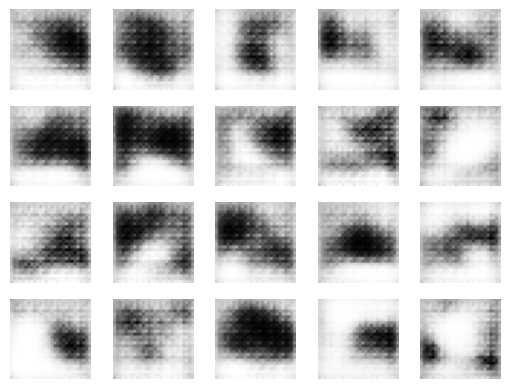

1/1 [==============================] - 0s 24ms/step
>94, cf=-8195.304, cr=-46125.694 g=-24002.871
1/1 [==============================] - 0s 24ms/step
>95, cf=-11650.903, cr=-46779.119 g=-20121.824
1/1 [==============================] - 0s 24ms/step
>96, cf=-8964.673, cr=-45673.180 g=-13935.953
1/1 [==============================] - 0s 24ms/step
>97, cf=-10953.125, cr=-44885.432 g=-14556.677
1/1 [==============================] - 0s 18ms/step
>98, cf=-15301.838, cr=-44410.636 g=-23749.408
1/1 [==============================] - 0s 18ms/step
>99, cf=-16122.830, cr=-44445.284 g=406.270
1/1 [==============================] - 0s 17ms/step
>100, cf=-15400.418, cr=-45403.831 g=-14266.034
1/1 [==============================] - 0s 17ms/step
>101, cf=-16204.033, cr=-40005.661 g=-5035.669
1/1 [==============================] - 0s 16ms/step
>102, cf=-4008.854, cr=-42243.927 g=-14824.571
1/1 [==============================] - 0s 19ms/step
>103, cf=-16562.054, cr=-43305.819 g=-2391.583
1/1 [=========

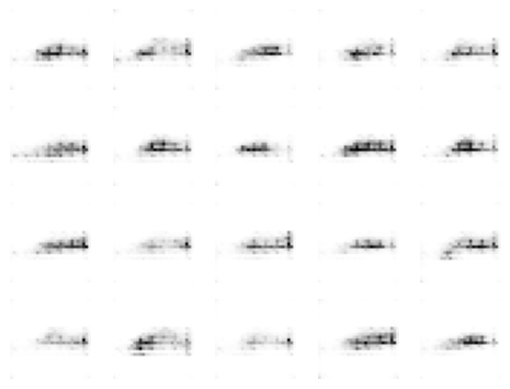

1/1 [==============================] - 0s 16ms/step
>187, cf=-389282.406, cr=-376110.369 g=-394680.531
1/1 [==============================] - 0s 16ms/step
>188, cf=-401394.969, cr=-384323.575 g=-399703.781
1/1 [==============================] - 0s 20ms/step
>189, cf=-405452.787, cr=-391121.606 g=-402029.375
1/1 [==============================] - 0s 18ms/step
>190, cf=-394120.950, cr=-382413.444 g=-408307.000
1/1 [==============================] - 0s 19ms/step
>191, cf=-418529.006, cr=-401783.681 g=-415473.281
1/1 [==============================] - 0s 19ms/step
>192, cf=-418365.906, cr=-401455.756 g=-419914.688
1/1 [==============================] - 0s 18ms/step
>193, cf=-421937.763, cr=-406081.069 g=-425355.750
1/1 [==============================] - 0s 18ms/step
>194, cf=-409098.575, cr=-392087.987 g=-429942.938
1/1 [==============================] - 0s 18ms/step
>195, cf=-440125.731, cr=-419044.006 g=-437020.562
1/1 [==============================] - 0s 19ms/step
>196, cf=-380221.628,

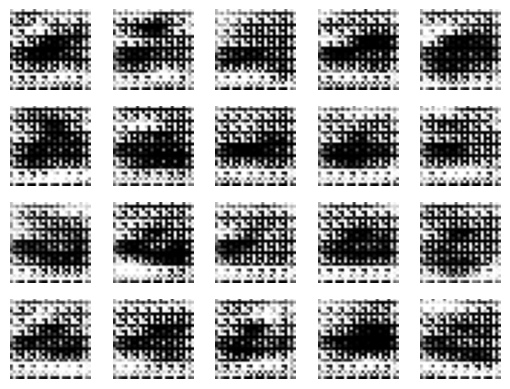

1/1 [==============================] - 0s 19ms/step
>280, cf=-644882.512, cr=-629600.225 g=517759.531
1/1 [==============================] - 0s 16ms/step
>281, cf=-652391.412, cr=-634106.238 g=517348.312
1/1 [==============================] - 0s 17ms/step
>282, cf=-662319.412, cr=-646866.600 g=556304.938
1/1 [==============================] - 0s 19ms/step
>283, cf=-688888.625, cr=-667999.475 g=578591.125
1/1 [==============================] - 0s 18ms/step
>284, cf=-678733.162, cr=-656200.075 g=598650.250
1/1 [==============================] - 0s 20ms/step
>285, cf=-703451.463, cr=-691377.262 g=609721.000
1/1 [==============================] - 0s 22ms/step
>286, cf=-696365.463, cr=-676578.387 g=605558.250
1/1 [==============================] - 0s 16ms/step
>287, cf=-725214.850, cr=-710557.725 g=616572.625
1/1 [==============================] - 0s 17ms/step
>288, cf=-719891.675, cr=-695760.213 g=644592.875
1/1 [==============================] - 0s 18ms/step
>289, cf=-743782.312, cr=-7298

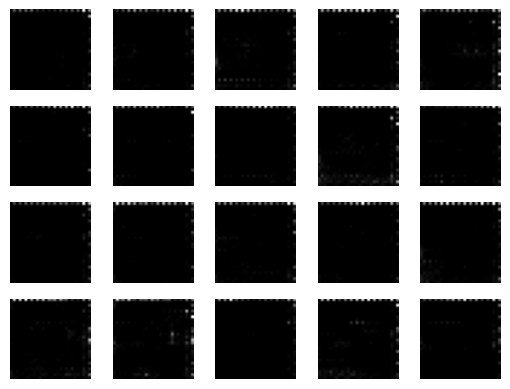

1/1 [==============================] - 0s 22ms/step
>373, cf=-1580914.950, cr=-1601084.850 g=1585879.750
1/1 [==============================] - 0s 20ms/step
>374, cf=-1592985.375, cr=-1615252.525 g=1598978.375
1/1 [==============================] - 0s 29ms/step
>375, cf=-1605582.075, cr=-1627120.550 g=1611535.500
1/1 [==============================] - 0s 34ms/step
>376, cf=-1617862.775, cr=-1638522.025 g=1624190.750
1/1 [==============================] - 0s 28ms/step
>377, cf=-1630287.550, cr=-1656507.425 g=1636666.000
1/1 [==============================] - 0s 31ms/step
>378, cf=-1643133.425, cr=-1666457.700 g=1649584.750
1/1 [==============================] - 0s 28ms/step
>379, cf=-1656019.125, cr=-1679731.850 g=1662029.625
1/1 [==============================] - 0s 20ms/step
>380, cf=-1668558.450, cr=-1690068.150 g=1675210.250
1/1 [==============================] - 0s 18ms/step
>381, cf=-1681355.475, cr=-1703365.200 g=1688023.250
1/1 [==============================] - 0s 17ms/step
>38

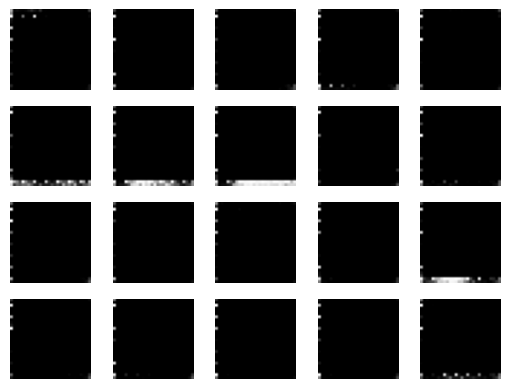

1/1 [==============================] - 0s 24ms/step
>466, cf=-3032126.000, cr=-3101701.250 g=-2673834.250
1/1 [==============================] - 0s 20ms/step
>467, cf=-3051664.000, cr=-3122304.850 g=-2696728.500
1/1 [==============================] - 0s 27ms/step
>468, cf=-3073051.000, cr=-3139815.500 g=-2794440.500
1/1 [==============================] - 0s 22ms/step
>469, cf=-3091446.900, cr=-3168283.150 g=-2830322.750
1/1 [==============================] - 0s 25ms/step
>470, cf=-3112743.800, cr=-3187967.650 g=-2826255.250
1/1 [==============================] - 0s 22ms/step
>471, cf=-3132045.400, cr=-3199326.400 g=-2940780.000
1/1 [==============================] - 0s 27ms/step
>472, cf=-3151145.350, cr=-3228429.050 g=-2968309.000
1/1 [==============================] - 0s 18ms/step
>473, cf=-3170022.950, cr=-3249580.500 g=-2994432.000
1/1 [==============================] - 0s 18ms/step
>474, cf=-3190531.550, cr=-3270190.850 g=-2985202.250
1/1 [==============================] - 0s 18ms

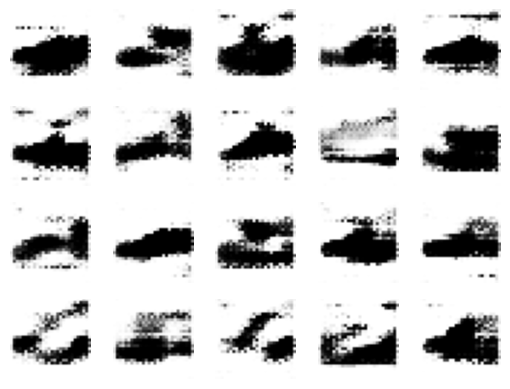

1/1 [==============================] - 0s 17ms/step
>559, cf=1489142.050, cr=-2823793.050 g=-1791925.625
1/1 [==============================] - 0s 23ms/step
>560, cf=1380784.450, cr=-2575020.800 g=-1358904.750
1/1 [==============================] - 0s 16ms/step
>561, cf=1566810.325, cr=-2769081.300 g=-1699598.125
1/1 [==============================] - 0s 16ms/step
>562, cf=1960702.875, cr=-2598283.700 g=-1765085.750
1/1 [==============================] - 0s 17ms/step
>563, cf=1621314.750, cr=-2759956.350 g=-1787467.500
1/1 [==============================] - 0s 16ms/step
>564, cf=1459322.575, cr=-2737952.350 g=-1279257.125
1/1 [==============================] - 0s 19ms/step
>565, cf=1318044.413, cr=-2553523.250 g=-1167656.250
1/1 [==============================] - 0s 16ms/step
>566, cf=1020435.225, cr=-2508359.650 g=-537166.750
1/1 [==============================] - 0s 29ms/step
>567, cf=522297.263, cr=-2551357.800 g=-842099.375
1/1 [==============================] - 0s 24ms/step
>568, 

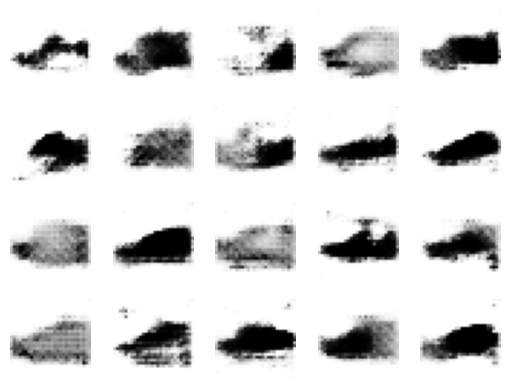

1/1 [==============================] - 0s 23ms/step
>652, cf=1594214.225, cr=-2339174.150 g=-2060381.250
1/1 [==============================] - 0s 25ms/step
>653, cf=1980462.800, cr=-2561155.350 g=-1887349.750
1/1 [==============================] - 0s 25ms/step
>654, cf=2052213.625, cr=-2542594.800 g=-1626979.750
1/1 [==============================] - 0s 16ms/step
>655, cf=1994820.050, cr=-2481523.450 g=-1489086.875
1/1 [==============================] - 0s 18ms/step
>656, cf=2142677.625, cr=-2409187.400 g=-1664990.250
1/1 [==============================] - 0s 21ms/step
>657, cf=1839188.625, cr=-2357794.700 g=-1722316.000
1/1 [==============================] - 0s 17ms/step
>658, cf=1626763.275, cr=-2234548.925 g=-1858622.375
1/1 [==============================] - 0s 24ms/step
>659, cf=2078680.025, cr=-2373419.500 g=-1881293.375
1/1 [==============================] - 0s 16ms/step
>660, cf=1910293.100, cr=-2496926.600 g=-1402204.500
1/1 [==============================] - 0s 17ms/step
>66

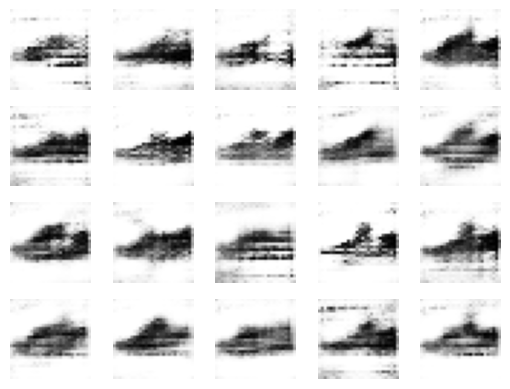

1/1 [==============================] - 0s 17ms/step
>745, cf=1225218.913, cr=-1997488.650 g=-1984184.875
1/1 [==============================] - 0s 17ms/step
>746, cf=1259881.225, cr=-1836176.675 g=-1938069.750
1/1 [==============================] - 0s 22ms/step
>747, cf=1546280.625, cr=-1919925.700 g=-1550286.750
1/1 [==============================] - 0s 19ms/step
>748, cf=1347755.675, cr=-1954148.400 g=-1668643.125
1/1 [==============================] - 0s 22ms/step
>749, cf=1197269.550, cr=-1917527.225 g=-1633376.500
1/1 [==============================] - 0s 18ms/step
>750, cf=1183051.875, cr=-1909483.600 g=-1578441.000
1/1 [==============================] - 0s 17ms/step
>751, cf=1278377.825, cr=-1950039.500 g=-1284781.750
1/1 [==============================] - 0s 16ms/step
>752, cf=1538643.450, cr=-1899082.200 g=-949496.562
1/1 [==============================] - 0s 17ms/step
>753, cf=1553384.700, cr=-1953455.900 g=-1297459.500
1/1 [==============================] - 0s 17ms/step
>754

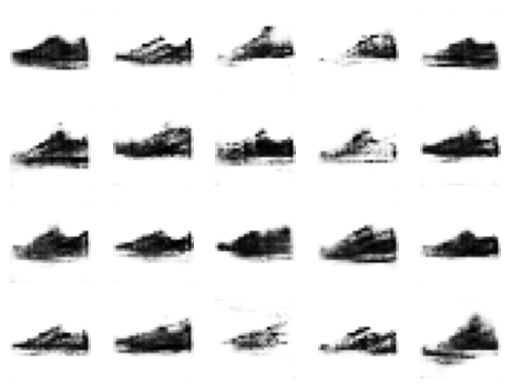

1/1 [==============================] - 0s 21ms/step
>838, cf=2075275.175, cr=-2045090.175 g=-1878176.875
1/1 [==============================] - 0s 27ms/step
>839, cf=2093930.750, cr=-2034439.175 g=-1865488.500
1/1 [==============================] - 0s 38ms/step
>840, cf=2043240.050, cr=-2033770.500 g=-1806918.500
1/1 [==============================] - 0s 86ms/step
>841, cf=2047003.425, cr=-2055252.875 g=-1770126.000
1/1 [==============================] - 0s 71ms/step
>842, cf=2045852.975, cr=-2079035.250 g=-1785005.250
1/1 [==============================] - 0s 27ms/step
>843, cf=2047703.375, cr=-2080228.825 g=-1788381.500
1/1 [==============================] - 0s 26ms/step
>844, cf=2055419.875, cr=-2060656.650 g=-1904827.250
1/1 [==============================] - 0s 19ms/step
>845, cf=2090316.500, cr=-2119145.000 g=-1947044.250
1/1 [==============================] - 0s 18ms/step
>846, cf=2113305.750, cr=-2099703.925 g=-1826429.000
1/1 [==============================] - 0s 18ms/step
>84

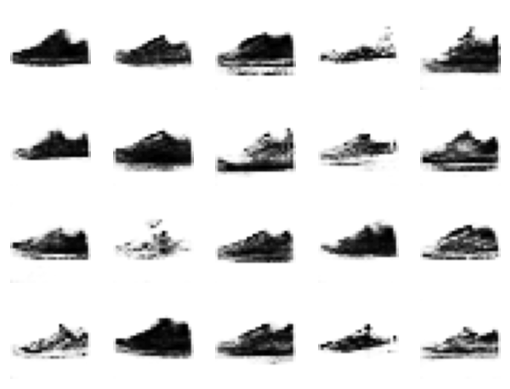

In [ ]:
start = time()
train_model(x_train, gan_model, generator, critic)
end = time()
duration = end - start

In [ ]:
total_time = "Time: {}".format(sec_to_hours(duration))
print(total_time)

Time: 0 hours 7 mins 46 seconds


In [ ]:
gan_file = str(model_dir) + '/gan_model.h5'
critic_file = str(model_dir) + '/critic_model.h5'
generator_file = str(model_dir) + '/generator_model.h5'

In [ ]:
gan_model.save(gan_file)
critic.save(critic_file)
generator.save(generator_file)

# **Evaluate**

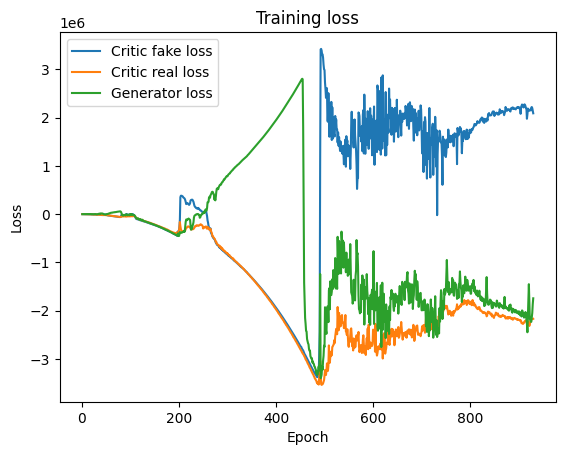

In [ ]:
# Plot history loss
epochs = np.arange(len(critic_fake_loss)) + 1

plt.figure()
plt.plot(epochs, critic_fake_loss, label='Critic fake loss')
plt.plot(epochs, critic_real_loss, label='Critic real loss')
plt.plot(epochs, gan_loss, label='Generator loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training loss')
plt.legend()
plt.savefig(output_dir / "Training_Loss.png")

1/1 [==============================] - 0s 42ms/step


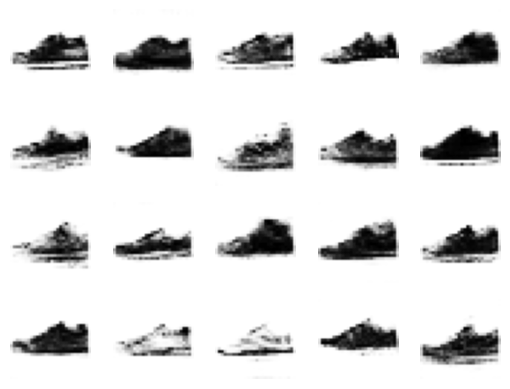

In [ ]:
summarize_performance(generator, latent_dim)